# Classification models training

Use this notebook to train classification models (KNN, SVM, etc) on leaf color classification.

In [ ]:
# Use pre-annotated dataset with each leaf segmentation and class
# From the data.yaml of this dataset, the label number to corresponding class is:
# 0=dark, 1=dead, 2=light, 3=medium

# This creates a list called 'obj_data', which containg every object as a tuple...
# ...containing (obj_classnum, obj_crop)

import scg_detection_tools.utils.image_tools as imtools
import scg_detection_tools.utils.cvt as cvt
from scg_detection_tools.utils.file_handling import get_all_files_from_paths
from scg_detection_tools.dataset import read_dataset_annotation
from analyze import parse_seg_annotations
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_DIR = "/home/juliocesar/leaf-detection/imgs/light_group/images"
LBL_DIR = "/home/juliocesar/leaf-detection/imgs/light_group/labels"

imgs = get_all_files_from_paths(IMG_DIR, skip_ext=[".txt", ".json", ".yaml"])
ann_files, img_ann_idx = parse_seg_annotations(imgs, LBL_DIR)

# Keep track of every object as (nclass, obj_crop)
obj_data = []

# CHOOSING 32x32 because of calculated average
STANDARD_SIZE = (32, 32)
MAX_MEDIUM = 150 # avoid making dataset unbalanced
curr_medium = 0

# !!!!!! taken from data.yaml
class_map = {0: "dark", 1: "dead", 2: "light", 3: "medium"}

for img in imgs:
    ann_file = ann_files[img_ann_idx[img]]
    annotations = read_dataset_annotation(ann_file, separate_class=False)

    # check if contours are boxes or segments
    orig = cv2.imread(img)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    imgsz = orig.shape[:2]

    for ann in annotations:
        nclass = ann[0]
        if nclass == 3:
            if curr_medium >= MAX_MEDIUM:
                continue
            else:
                curr_medium += 1

        contour = ann[1:]
        if len(contour) == 4:
            mask = cvt.boxes_to_masks([contour], imgsz=imgsz, normalized=True)[0]
        else:
            mask = cvt.contours_to_masks([contour], imgsz=imgsz, normalized=True)[0]
        
        # get only segmented object from image
        masked = orig.copy()
        masked[mask[:,:] < 255] = 0

        # crop a box around it
        points = np.array(contour).reshape(len(contour) // 2, 2)
        box = cvt.segment_to_box(points, normalized=True, imgsz=imgsz)
        obj_crop = imtools.crop_box_image(masked, box)

        # resize to 32x32 and add to our data
        obj_crop = cv2.resize(obj_crop, STANDARD_SIZE, cv2.INTER_CUBIC)
        obj_data.append((nclass, obj_crop))



In [2]:
# Split between Train and Test to evaluate model as well
from sklearn.model_selection import train_test_split

X = []
y = []
for nclass, obj_crop in obj_data:
    X.append(obj_crop)
    y.append(nclass)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [3]:
# Preprocessing functions (to be able to call clf.predict(imgs) instead of having to extract features first and then calling clf.predict(features))
# -> rn_feature_preprocess: use resnet feature extraction to train classificators
# -> channels_feature_preprocess: extract RGB, HSV and Gray values from a 32x32 image as features
def rn_feature_preprocess(objX):
    import numpy as np

    if not isinstance(objX[0], np.ndarray):
        raise TypeError("'objX' passed to preprocess function must be a list of np.ndarray RGB images")

    from analysis.classify import resnet_extract_features
    processed = []
    for obj in objX:
        processed.append(resnet_extract_features(obj))
    return processed


def channels_feature_preprocess(objX):
    import cv2
    import numpy as np

    if not isinstance(objX[0], np.ndarray):
        raise TypeError("'objX' passed to preprocess function must be a list of np.ndarray RGB images")

    processed = []
    for obj in objX:
        rgb = cv2.resize(obj, (32,32))
        hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
        gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

        attributes = np.concatenate((rgb.flatten(), hsv.flatten(), gray.flatten()))
        processed.append(attributes)

    return processed


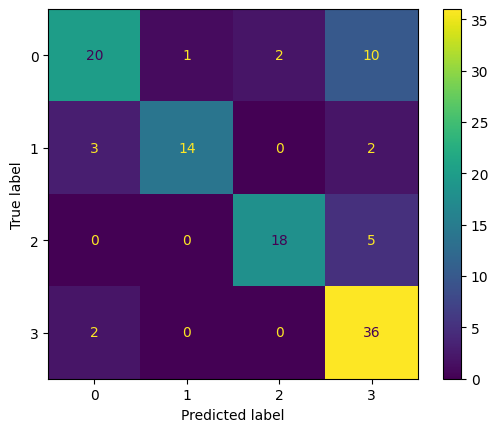

              precision    recall  f1-score   support

           0       0.80      0.61      0.69        33
           1       0.93      0.74      0.82        19
           2       0.90      0.78      0.84        23
           3       0.68      0.95      0.79        38

    accuracy                           0.78       113
   macro avg       0.83      0.77      0.79       113
weighted avg       0.80      0.78      0.78       113



In [4]:
#####################################################
##### TRAIN KNN WITH RESNET FEATURE EXTRACTION #####
#####################################################

from analysis.classify import KNNClassifier

resnet_knn = KNNClassifier(n_neighbors=7, preprocess=rn_feature_preprocess)
resnet_knn.train(X_train, y_train)
resnet_knn.evaluate(X_test, y_test)

In [5]:
resnet_knn.save_state("knn_rn34_k7.skl")

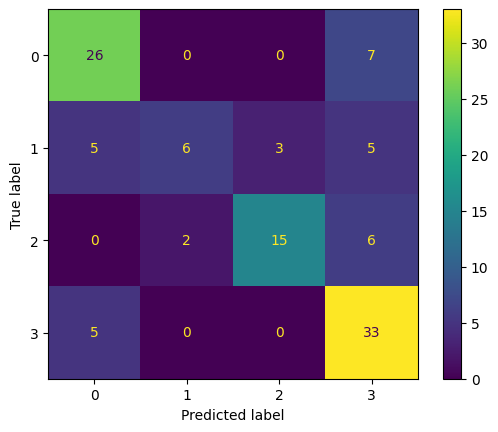

              precision    recall  f1-score   support

           0       0.72      0.79      0.75        33
           1       0.75      0.32      0.44        19
           2       0.83      0.65      0.73        23
           3       0.65      0.87      0.74        38

    accuracy                           0.71       113
   macro avg       0.74      0.66      0.67       113
weighted avg       0.72      0.71      0.69       113



In [6]:
#############################################################
##### TRAIN KNN WITH MANUAL CHANNELS FEATURE EXTRACTION #####
#############################################################

knn = KNNClassifier(n_neighbors=3, preprocess=channels_feature_preprocess)
knn.train(X_train, y_train)
knn.evaluate(X_test, y_test)

In [7]:
knn.save_state("knn_k3.skl")

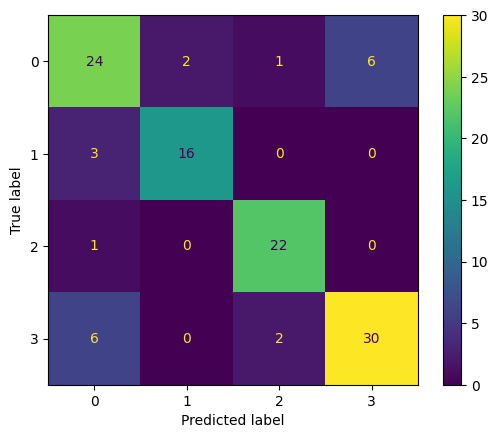

              precision    recall  f1-score   support

           0       0.71      0.73      0.72        33
           1       0.89      0.84      0.86        19
           2       0.88      0.96      0.92        23
           3       0.83      0.79      0.81        38

    accuracy                           0.81       113
   macro avg       0.83      0.83      0.83       113
weighted avg       0.81      0.81      0.81       113



In [8]:
####################################################
##### TRAIN SVM WITH RESNET FEATURE EXTRACTION #####
####################################################

from analysis.classify import SVMClassifier

sv = SVMClassifier(preprocess=rn_feature_preprocess)
sv.train(X_train, y_train)
sv.evaluate(X_test, y_test)

In [9]:
sv.save_state("svm_rn34.skl")

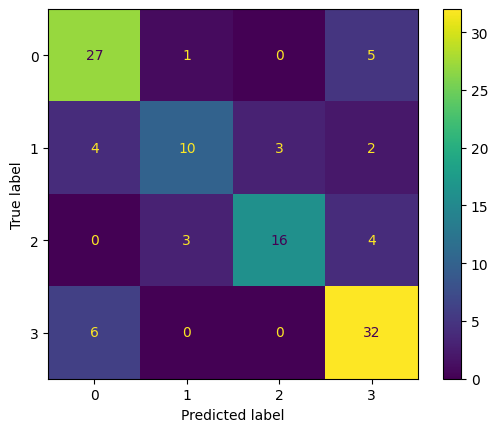

              precision    recall  f1-score   support

           0       0.73      0.82      0.77        33
           1       0.71      0.53      0.61        19
           2       0.84      0.70      0.76        23
           3       0.74      0.84      0.79        38

    accuracy                           0.75       113
   macro avg       0.76      0.72      0.73       113
weighted avg       0.75      0.75      0.75       113



In [10]:
############################################################
##### TRAIN SVM WITH MANUAL CHANNEL FEATURE EXTRACTION #####
############################################################

from analysis.classify import SVMClassifier

sv = SVMClassifier(preprocess=channels_feature_preprocess)
sv.train(X_train, y_train)
sv.evaluate(X_test, y_test)

In [11]:
sv.save_state("svm.skl")